In [1]:
# Move files

import csv

labels_file = 'train.csv'
labels = set()
file_map = dict()

with open(labels_file) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count > 0:
            filename = row[1]+'.jpg'
            label = row[2]
            
            file_map[filename] = label
            labels.add(label)
            
        line_count += 1

print(labels)
print(file_map)

{'4', '7', '2', '1', '10', '8', '11', '0', '3', '5', '12', '13', '15', '9', '14', '6'}
{'0.jpg': '7', '1.jpg': '2', '2.jpg': '1', '3.jpg': '7', '4.jpg': '1', '5.jpg': '2', '6.jpg': '6', '7.jpg': '10', '8.jpg': '10', '9.jpg': '2', '10.jpg': '2', '11.jpg': '8', '12.jpg': '7', '13.jpg': '8', '14.jpg': '7', '15.jpg': '11', '16.jpg': '2', '17.jpg': '14', '18.jpg': '2', '19.jpg': '6', '20.jpg': '2', '21.jpg': '12', '22.jpg': '2', '23.jpg': '11', '24.jpg': '9', '25.jpg': '5', '26.jpg': '7', '27.jpg': '11', '28.jpg': '9', '29.jpg': '8', '30.jpg': '0', '31.jpg': '2', '32.jpg': '11', '33.jpg': '7', '34.jpg': '2', '35.jpg': '15', '36.jpg': '6', '37.jpg': '1', '38.jpg': '1', '39.jpg': '11', '40.jpg': '7', '41.jpg': '3', '42.jpg': '13', '43.jpg': '7', '44.jpg': '1', '45.jpg': '14', '46.jpg': '11', '47.jpg': '2', '48.jpg': '2', '49.jpg': '2', '50.jpg': '1', '51.jpg': '2', '52.jpg': '15', '53.jpg': '5', '54.jpg': '7', '55.jpg': '2', '56.jpg': '8', '57.jpg': '12', '58.jpg': '1', '59.jpg': '4', '60.jpg

In [2]:
# create directories
import os
base = 'data/train/'
for l in labels:
    os.mkdir(base+l)
    
    
        

FileExistsError: [Errno 17] File exists: 'data/train/4'

In [34]:
for fname in file_map.keys():
    dname = file_map[fname]
    os.rename(base+fname, base+dname+'/'+fname)

In [32]:
names_dict = {
0: 'Bar',
1: 'Bathroom',
2: 'Bedroom',
3: 'Breakfast',
4: 'City View',
5: 'Dining',
6: 'Hotel Front',
7: 'Hotel Exterior View',
8: 'Hotel Interior View',
9: 'Kitchen',
10: 'Living Room',
11: 'Lobby',
12: 'Natural View',
13: 'Pool',
14: 'Recreation',
15: 'Sports'}

label_to_names =  dict()
for k in names_dict.keys():
    v = names_dict[k]
    label_to_names[v] = k



In [42]:
# Rename

for k in names_dict.keys():
    v = names_dict[k]
    os.rename(base+str(k), base+v)

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
data_transforms = {
    'train': transforms.Compose([
        #transforms.Resize(310),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #transforms.CenterCrop(299),
        transforms.RandomHorizontalFlip(),
        #transforms.RandomRotation(10),
        transforms.ColorJitter(),
        transforms.ToTensor() ,
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        # transforms.Resize(310),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #transforms.CenterCrop(299),
        transforms.ToTensor() ,
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        # transforms.Resize(310),
        transforms.Resize(256),
         transforms.CenterCrop(224),
        #transforms.CenterCrop(299),
        transforms.ToTensor() ,
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
data_dir = 'data/'
image_datasets = {'train': datasets.ImageFolder(data_dir+'train',
                                          data_transforms['train']),
                  'test': ImageFolderWithPaths(data_dir+'test',
                                          data_transforms['test']) 
                  }

# 1 Batch size 4 - learning rate 0.001 - 1 epoch - learning rate decay every 7 0.45516 0.53 acc resnet18
# 2 Batch Size 64 learning rate 0.0008 - 20 epochs (14 ok) - learning rate decay every 10 0.8 acc 0.57594 resnet18
# 3 Batch Size 64 learning rate default - 35 epochs - 0.511 Adam acc 0.8047 resnet50
# 4 Batch Size 16 learning rate 0.001 - 8 epochs - 0.64 0.94 acc vgg19
# 5 Batch Size 16 learning rate 0.001 - 20 epochs - 0.62418 0.9854 acc vgg19_bn
# 6 Batch Size 16 learning rate 0.001 - 40 epochs - 0.66 0.9854 acc vgg19_bn
# 8 Batch Size 16 learning rate 1e-6 - 40 epochs - 0.63 0.8 acc densenet161 RMSProp
# 9 Batch Size 16 learning rate 1e-7 - 100 epochs - 0.49 0.7 acc densenet161 RMSProp
# 9 Batch Size 16 learning rate 1e-6 - 90 epochs - 0.63 0.8 acc densenet161 RMSProp
# 13 Batch Size 16 learning rate 1e-6 - 80 epchs - 0.64  0.95 acc 0.82 valacc resnet50 (from scratch ) Adam
# * 14 Batch Size 16 learning rate 1e-6 - 37 epchs (20?) - 0.65304 <3  0.95 acc 0.83 valacc resnet152 (from scratch ) Adam
# 15 Batch Size 16 learning rate 8e-7 - 37 epchs(20?) - 0.64 nah 0.95 acc 0.83 valacc resnet152 (from scratch ) Adam
# 16 resnet152_Adam-1e-06-60ep16bs_1562508327 0.6507479833577965
# Batch Size 16 learning rate 1e-6 - 80 epchs  - inception (from scratch ) Adagrad
# Batch Size 16 learning rate 1e-6 - 80 epchs  - inception (from scratch ) Adamax
# next Batch Size 16 learning rate 7e-7 - 80 epchs  - inception (from scratch ) Adam
# next Batch Size 32 learning rate 1e-6 - 80 epchs  - inception (from scratch ) Adam
# probar Batch Size 16 learning rate 4e-7 - 37 epchs -  resnet152 (from scratch ) Adam
# probar  Sin color gittler Batch Size 16 learning rate 1e-6 - 37 epchs (20?) - 0.65304 <3  0.95 acc 0.83 valacc resnet152 (from scratch ) Adam
# probar  Batch Size 32 learning rate 1e-6 - 37 epchs (20?) - 0.65304 <3  0.95 acc 0.83 valacc resnet152 (from scratch ) Adam
# Objetivo: superar el 83% Target minimo 87%
# final 1: Batch Size 16 learning rate 1e-6 - 20 epchs resnet152 TODO TRAINING SET
# * 14 Batch Size 16 learning rate 1e-6 - 30 epchs (20?) 0.71888 --corregido
# * 14 Batch Size 16 learning rate 1e-6 - 30 epchs (20?) 0.76 weighted --corregido

batch_size = 16
use_validation = True
dataloaders = dict()

if use_validation:
    validation_split = .2
    random_seed= 17

    dataset_size = len(image_datasets['train'])
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]

    dataset_sizes = {'train': len(train_indices), 'valid': len(val_indices)}
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)
   
    dataloaders['train'] = DataLoader(image_datasets['train'], batch_size=batch_size,  sampler=train_sampler)
    dataloaders['valid'] = DataLoader(image_datasets['train'], batch_size=batch_size,  sampler=valid_sampler)
else:
    dataloaders['train'] = DataLoader(image_datasets['train'], batch_size=batch_size,  shuffle=True)

dataloaders['test'] = DataLoader(image_datasets['test'], batch_size=batch_size)

class_names = image_datasets['train'].classes
print(class_names)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

['Bar', 'Bathroom', 'Bedroom', 'Breakfast', 'City View', 'Dining', 'Hotel Front', 'Hotel Front2 -Exterior View', 'Hotel Interior View', 'Kitchen', 'Living Room', 'Lobby', 'Natural View', 'Pool', 'Recreation', 'Sports']


In [61]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    stats = dict()
    
    print("Use validation set: ", use_validation)
    
    training_phases = ['train']
    if use_validation:
        training_phases.append('valid')
    
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    epoch_loss = dict()
    epoch_acc = dict()
    epoch_loss['train'] = list()
    epoch_acc['train'] = list()

    if use_validation:
        epoch_loss['valid'] = list()
        epoch_acc['valid'] = list()
    

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Para cada epoca hago un entrenamiento una validación
        val_loss = 0.0
        for phase in training_phases:
            
            if phase == 'train':
                if scheduler:
                    scheduler.step(val_loss)
                model.train()  # Set model to training mode
            else: 
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.cuda()
                labels = labels.cuda()

                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    
                    if model_name == 'inception' and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)
                        
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                

            epoch_loss[phase].append(running_loss / dataset_sizes[phase])
            epoch_acc[phase].append(running_corrects.double() / dataset_sizes[phase])

            if phase == 'valid':
                val_loss = epoch_loss['valid']
            
        if use_validation:
            print('loss: {:.4f} val_loss: {:.4f} acc: {:.4f} val_acc: {:.4f}'.format( \
                    epoch_loss['train'][-1], epoch_loss['valid'][-1], epoch_acc['train'][-1], \
                     epoch_acc['valid'][-1]))
        else:
            print('loss: {:.4f}  acc: {:.4f}  '.format( \
                    epoch_loss['train'][-1], epoch_acc['train'][-1]))
        
        if use_validation:
            if phase == 'valid' and epoch_acc['valid'][-1] > best_acc:
                best_acc = epoch_acc['valid'][-1]
                print("Saved at epoch.")
                best_model_wts = copy.deepcopy(model.state_dict())
        else:
            if epoch_acc['train'][-1] > best_acc:
                best_acc = epoch_acc['train'][-1]
                best_model_wts = copy.deepcopy(model.state_dict())
                print("Saved at epoch.")
            
    stats['loss'] = epoch_loss
    stats['acc'] = epoch_acc
            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    model.load_state_dict(best_model_wts)
    return model, stats

num_classes= 16

'''
model_name = 'resnet152' # model_name : alexnet, resnet, vgg19
learning_rate = 1e-4
scheduler_step = None
epochs = 40 (20)
optimizer_name = 'Adagrad' # optimizer_name: SGD, Adam, RMSProp
feature_extract = False
lr_decay = 1e-6
weight_decay=0.01
'''

model_name = 'densenet' # model_name : alexnet, resnet, vgg19
learning_rate = 1e-6
scheduler_step = (dataset_sizes['train']//16) 
epochs = 15
optimizer_name = 'SGD' # optimizer_name: SGD, Adam, RMSProp
feature_extract = False
lr_decay = 1e-4
weight_decay= 0.02

if model_name == "densenet":
    model_ft = models.densenet201(pretrained=True)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier.in_features
    model_ft.classifier = nn.Linear(num_ftrs, num_classes)
if model_name == 'alexnet':
    model_ft = models.alexnet(pretrained=True)
    model_ft.classifier[6] = nn.Linear(4096,num_classes)
if model_name == 'vgg19_bn':
    model_ft = models.vgg19_bn(pretrained=True)
    set_parameter_requires_grad(model_ft, feature_extract)    
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
if model_name == 'resnet50':
    model_ft = models.resnet50(pretrained=True)
    set_parameter_requires_grad(model_ft, feature_extract)    
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)     
if model_name == 'resnet152':
    model_ft = models.resnet152(pretrained=True)
    set_parameter_requires_grad(model_ft, feature_extract)    
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)   
if model_name == 'inception':    
    model_ft = models.inception_v3(pretrained=True)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.AuxLogits.fc.in_features
    model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs,num_classes)    

model_ft = model_ft.cuda()


if optimizer_name == 'SGD':
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=learning_rate, momentum=0.9)

if optimizer_name == 'Adam':
    optimizer_ft = optim.Adam(model_ft.parameters(), lr=learning_rate)

if optimizer_name == 'RMSprop':
    optimizer_ft = optim.RMSprop(model_ft.parameters(), lr=learning_rate)

if optimizer_name == 'Adamax':
    optimizer_ft = optim.Adamax(model_ft.parameters(), lr=learning_rate)

if optimizer_name == 'Adadelta':
    optimizer_ft = optim.Adadelta(model_ft.parameters(), lr=learning_rate)

if optimizer_name == 'Adagrad':
    optimizer_ft = optim.Adagrad(model_ft.parameters(), lr=learning_rate, lr_decay=lr_decay, weight_decay = weight_decay)
    
    
weights = torch.FloatTensor([29.7195
,4.2493
,1.0
,7.2638
,9.2136
,10.7594
,5.8582
,4.9887
,6.1385
,10.8795
,10.2395
,7.0434
,7.0332
,11.4413
,19.1137
,22.2557
]).cuda()


criterion = nn.CrossEntropyLoss(reduction='sum', weight=weights)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = None
if scheduler_step:
    #exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=scheduler_step, gamma=0.1)
    #exp_lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_ft,T_max=64) 12 epochs va con lr=1e-6
    exp_lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, threshold=1e-2, mode='min')
    
#optimizer-LR-Scheduler-Epochs
extra_info = optimizer_name+'_'+str(learning_rate)
if scheduler_step:
    extra_info += '_LRSched'+str(scheduler_step)
extra_info += '_'+str(epochs)+'ep'+str(batch_size)+'bs'
print(extra_info)

model_ft, stats = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=epochs)



SGD_1e-06_LRSched682_15ep16bs
Use validation set:  True
Epoch 0/14
----------
loss: 198.0396 val_loss: 129.7858 acc: 0.4595 val_acc: 0.6608
Saved at epoch.
Epoch 1/14
----------
loss: 120.7803 val_loss: 91.1105 acc: 0.6896 val_acc: 0.7429
Saved at epoch.
Epoch 2/14
----------
loss: 94.1108 val_loss: 79.0245 acc: 0.7198 val_acc: 0.7619
Saved at epoch.
Epoch 3/14
----------
loss: 79.8592 val_loss: 72.0365 acc: 0.7476 val_acc: 0.7685
Saved at epoch.
Epoch 4/14
----------
loss: 70.6210 val_loss: 69.5579 acc: 0.7679 val_acc: 0.7707
Saved at epoch.
Epoch 5/14
----------
loss: 62.2352 val_loss: 66.5702 acc: 0.7903 val_acc: 0.7872
Saved at epoch.
Epoch 6/14
----------
loss: 55.5441 val_loss: 65.4933 acc: 0.8052 val_acc: 0.7894
Saved at epoch.
Epoch 7/14
----------
loss: 49.3667 val_loss: 65.3575 acc: 0.8229 val_acc: 0.7824
Epoch 8/14
----------
loss: 43.5181 val_loss: 66.6391 acc: 0.8437 val_acc: 0.8033
Saved at epoch.
Epoch 9/14
----------
loss: 38.9879 val_loss: 67.3257 acc: 0.8571 val_acc: 

[198.03963834881347, 120.78026611551697, 94.11076865004095, 79.85921008560683, 70.62101033528646, 62.23524347172552, 55.54409790667859, 49.36666337456895, 43.51807058005979, 38.987938221732335, 35.13742931037596, 31.614750754527556, 30.788407042786314, 30.76056373791817, 30.363654060503503]
[129.78580973978006, 91.11053699311756, 79.02445435576387, 72.03653653322995, 69.55793900542207, 66.5702208061358, 65.49330858642801, 65.35745153462057, 66.639111328125, 67.32565167046292, 67.08163677117763, 67.262369290027, 67.67276038983803, 66.41427776630108, 66.53295014070504]


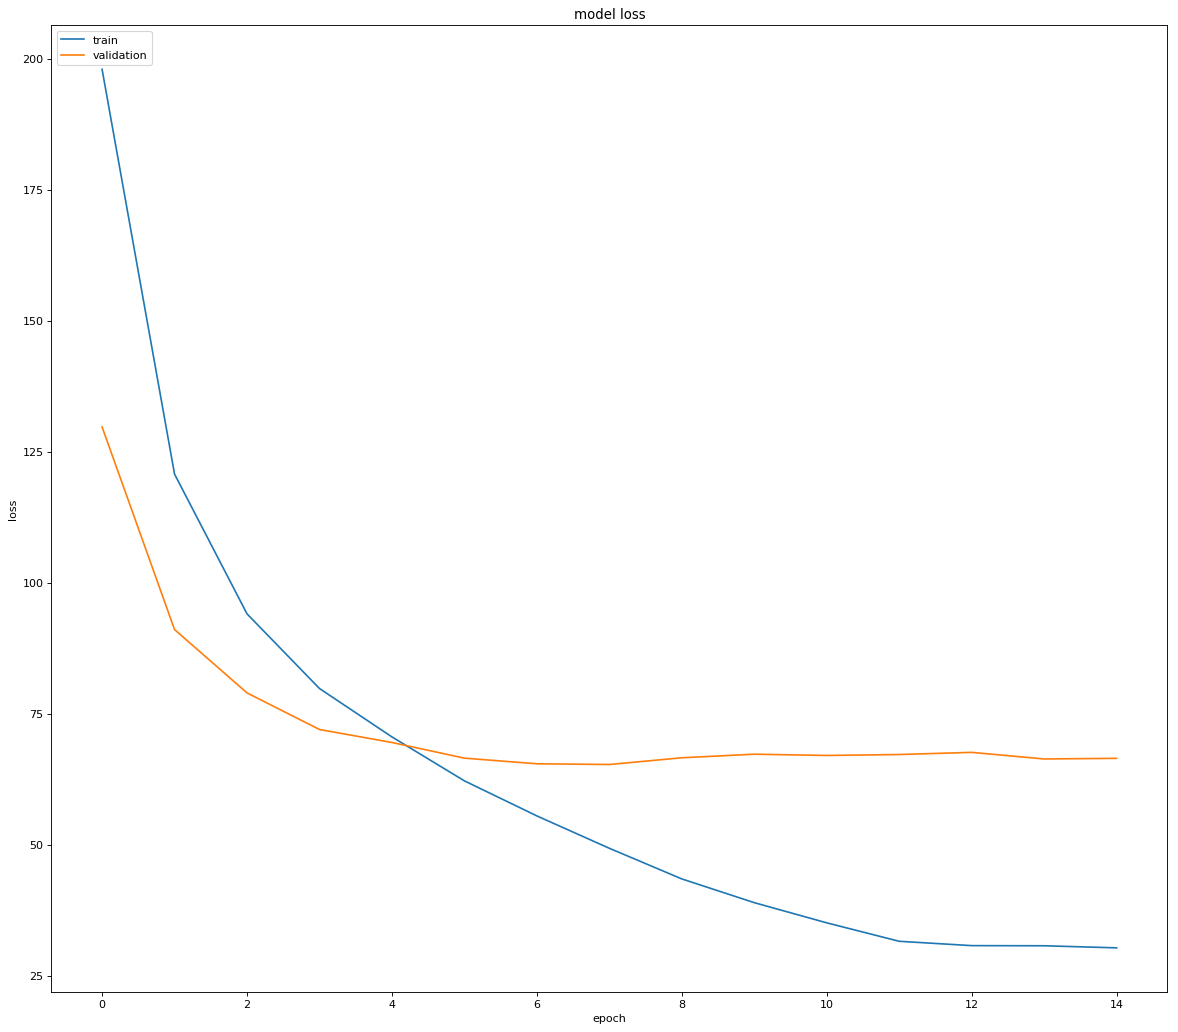

<Figure size 432x288 with 0 Axes>

In [64]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(stats['loss']['train'])
plt.plot(stats['loss']['valid'])
print(stats['loss']['train'])
print(stats['loss']['valid'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.savefig(model_name+"_"+extra_info+"_"+str(round(time.time()))+".png")

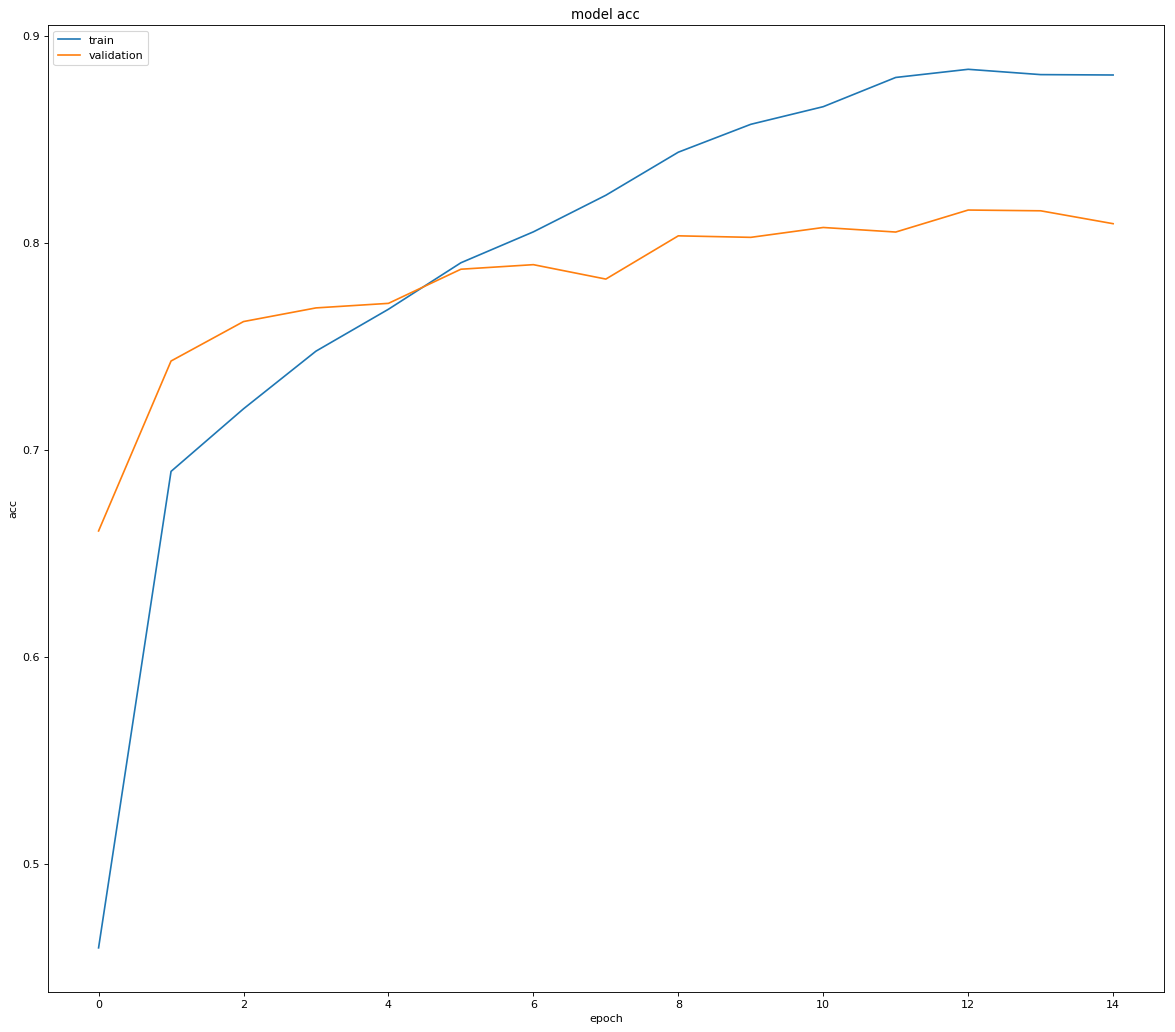

<Figure size 432x288 with 0 Axes>

In [66]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(stats['acc']['train'])
plt.plot(stats['acc']['valid'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()


In [67]:
!pip install sklearn
from sklearn.metrics import balanced_accuracy_score

def get_eval(model, dataid):
    y_true = []
    y_pred = []
    model.cuda().eval()

    with torch.no_grad():
        for inputs, labels  in dataloaders['valid']:
            
            inputs = inputs.cuda()
            

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_pred += preds.tolist()
            y_true += labels.data.cpu().tolist()
    return  y_true, y_pred
    


tensorboard 1.7.0 has requirement bleach==1.5.0, but you'll have bleach 3.0.2 which is incompatible.
tensorboard 1.7.0 has requirement html5lib==0.9999999, but you'll have html5lib 1.0.1 which is incompatible.
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [68]:
#prev: 0.718772239949943
# 13 best 0.7327765858686976

y_true, y_pred = get_eval(model_ft,'valid')
balanced_accuracy_score(y_true, y_pred)

    


0.7762971051584675

In [71]:
file_name = model_name+"_"+extra_info+"_"+str(round(time.time()))+".pth"

torch.save(model_ft.state_dict(), file_name)

In [11]:
def eval_model(model):
    res = []
    model.cuda().eval()

    with torch.no_grad():
        for i, inputs  in enumerate(dataloaders['test']):
            filenames = inputs[2]
            inputs = inputs[0]
            inputs = inputs.cuda()
            

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                value = int(preds[j])
                filename = int(filenames[j].replace('.jpg','').replace('data/test/0/',''))
                res.append( (filename,value) )
    return res

res = eval_model(model_ft)
res.sort()
for x in res:
    print(str(x[0])+','+str(x[1]))

0,8
1,2
2,3
3,14
4,5
5,6
6,2
7,3
8,11
9,2
10,2
11,0
12,6
13,14
14,6
15,11
16,2
17,6
18,3
19,13
20,2
21,2
22,13
23,1
24,11
25,2
26,6
27,2
28,2
29,8
30,6
31,2
32,4
33,11
34,5
35,13
36,4
37,2
38,2
39,7
40,2
41,2
42,8
43,2
44,2
45,10
46,1
47,1
48,2
49,8
50,2
51,2
52,10
53,7
54,9
55,10
56,13
57,2
58,11
59,2
60,2
61,2
62,2
63,12
64,7
65,2
66,5
67,2
68,9
69,4
70,13
71,5
72,10
73,13
74,2
75,3
76,8
77,2
78,10
79,12
80,6
81,2
82,2
83,10
84,2
85,14
86,2
87,12
88,2
89,2
90,7
91,11
92,2
93,15
94,2
95,12
96,1
97,2
98,6
99,2
100,1
101,15
102,1
103,8
104,11
105,2
106,2
107,2
108,2
109,1
110,3
111,5
112,2
113,12
114,8
115,2
116,4
117,2
118,8
119,2
120,1
121,2
122,13
123,6
124,5
125,7
126,6
127,4
128,2
129,2
130,7
131,13
132,12
133,2
134,11
135,4
136,14
137,2
138,7
139,12
140,1
141,13
142,2
143,2
144,2
145,12
146,8
147,2
148,2
149,11
150,8
151,13
152,1
153,12
154,2
155,2
156,13
157,10
158,2
159,2
160,9
161,8
162,4
163,11
164,1
165,12
166,2
167,2
168,2
169,1
170,6
171,0
172,3
173,2
174,13
175,6
176,6
177

3420,10
3421,2
3422,7
3423,11
3424,1
3425,0
3426,5
3427,2
3428,14
3429,6
3430,11
3431,2
3432,10
3433,2
3434,2
3435,2
3436,6
3437,2
3438,1
3439,14
3440,4
3441,2
3442,6
3443,13
3444,2
3445,15
3446,5
3447,12
3448,7
3449,2
3450,7
3451,12
3452,2
3453,2
3454,2
3455,8
3456,12
3457,1
3458,2
3459,15
3460,2
3461,6
3462,2
3463,2
3464,2
3465,2
3466,2
3467,2
3468,2
3469,2
3470,9
3471,4
3472,4
3473,15
3474,2
3475,9
3476,6
3477,2
3478,11
3479,2
3480,2
3481,1
3482,13
3483,2
3484,2
3485,8
3486,1
3487,8
3488,7
3489,2
3490,2
3491,2
3492,2
3493,11
3494,2
3495,2
3496,2
3497,4
3498,6
3499,2
3500,11
3501,2
3502,3
3503,15
3504,2
3505,2
3506,5
3507,3
3508,3
3509,11
3510,12
3511,2
3512,4
3513,2
3514,8
3515,8
3516,11
3517,5
3518,2
3519,8
3520,13
3521,2
3522,10
3523,7
3524,6
3525,4
3526,2
3527,3
3528,5
3529,5
3530,10
3531,7
3532,14
3533,10
3534,1
3535,2
3536,12
3537,2
3538,10
3539,12
3540,2
3541,14
3542,1
3543,2
3544,6
3545,3
3546,2
3547,11
3548,2
3549,2
3550,2
3551,5
3552,8
3553,12
3554,3
3555,1
3556,8
3557,8
35

7298,2
7299,6
7300,2
7301,5
7302,2
7303,2
7304,2
7305,9
7306,2
7307,2
7308,0
7309,14
7310,2
7311,2
7312,2
7313,1
7314,2
7315,1
7316,2
7317,2
7318,10
7319,2
7320,8
7321,1
7322,2
7323,8
7324,2
7325,3
7326,1
7327,8
7328,4
7329,8
7330,6
7331,10
7332,2
7333,0
7334,2
7335,2
7336,6
7337,2
7338,2
7339,3
7340,7
7341,3
7342,11
7343,9
7344,9
7345,1
7346,11
7347,2
7348,2
7349,7
7350,1
7351,2
7352,5
7353,9
7354,2
7355,2
7356,2
7357,2
7358,2
7359,6
7360,7
7361,10
7362,6
7363,2
7364,10
7365,2
7366,2
7367,1
7368,11
7369,2
7370,7
7371,15
7372,12
7373,12
7374,2
7375,0
7376,12
7377,10
7378,1
7379,5
7380,2
7381,2
7382,2
7383,2
7384,2
7385,5
7386,11
7387,2
7388,12
7389,1
7390,2
7391,10
7392,2
7393,2
7394,12
7395,2
7396,15
7397,3
7398,14
7399,1
7400,2
7401,9
7402,8
7403,6
7404,5
7405,2
7406,3
7407,10
7408,5
7409,1
7410,6
7411,15
7412,2
7413,2
7414,2
7415,2
7416,2
7417,3
7418,2
7419,2
7420,4
7421,2
7422,2
7423,6
7424,6
7425,4
7426,15
7427,6
7428,10
7429,2
7430,13
7431,8
7432,7
7433,7
7434,12
7435,10
7436,13


Normalized confusion matrix


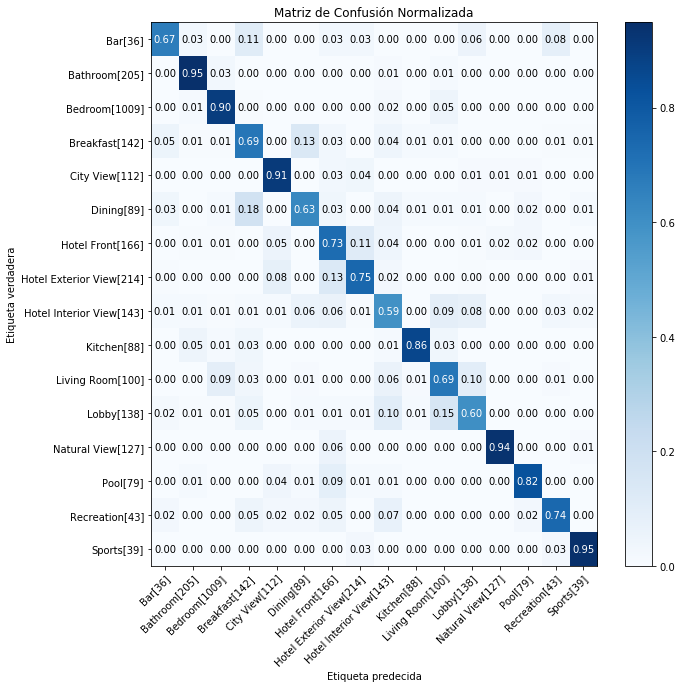

In [74]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from matplotlib.pyplot import figure
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Matriz de Confusión Normalizada'
        else:
            title = 'Matriz de Confusión, sin normalizar'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    categ_samples = cm.sum(axis=1)[:, np.newaxis]
    classes = [x+str(categ_samples[i]) for i,x in enumerate(classes)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Etiqueta verdadera',
           xlabel='Etiqueta predecida')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

class_names = names_dict.values()
# Plot non-normalized confusion matrix
#plot_confusion_matrix(y_true, y_pred, classes=class_names,
#                      title='Matriz de Confusión, sin normalizar')

# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True,
                      title='Matriz de Confusión Normalizada')
plt.savefig(model_name+"_"+extra_info+"_"+str(round(time.time()))+"-confmat.png")
plt.show()
